In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from oadap.utils import load_mat
from oadap.prediction.tcn.preprocessing import calculate_climatology, group, svd_decompose, reconstruct_data, uniform_sampling, create_windows

#### Load Data

In [4]:
data_dir = '../../data/FVCOM/'
array_path = data_dir + "salinity/salinity.mat"
# array_path = data_dir + "temperature/temp.mat"

lon = load_mat(data_dir + "x.mat")
lat = load_mat(data_dir + "y.mat")

h = load_mat(data_dir + "h.mat")  # (nx, 1) Distance from the surface to the ocean floor
siglay = load_mat(data_dir + "siglay.mat") # (nx, nz)
time = pd.date_range(start="1/1/2005", end="12/31/2013")

neighbors = np.load(data_dir + "neighbor_inds.npy").astype(np.int32)

nx = lon.shape[0]
nt = time.shape[0]
nz = siglay.shape[1]
n_neighbors = neighbors.shape[-1]

T = load_mat(array_path)
T = T.transpose((0, 2, 1))  # (nx, nt, nz)
assert T.shape == (nx, nt, nz)
temp_surface = T[..., 0]

In [5]:
phi = load_mat(data_dir + "temperature/phi.mat")
phi = phi.transpose((2, 0, 1))

In [7]:
lon = load_mat(data_dir + 'x.mat')
lat = load_mat(data_dir + 'y.mat')
xy = np.column_stack((lon, lat))

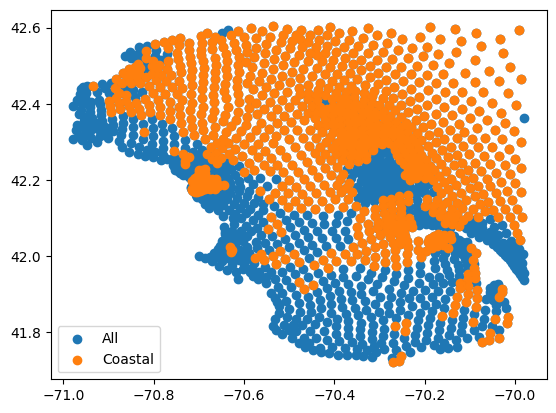

In [17]:
xy_c = xy[phi[:, 0, 1] > 0]
plt.scatter(xy[:, 0], xy[:, 1])
plt.scatter(xy_c[:, 0], xy_c[:, 1])
plt.legend(['All', 'Coastal'])

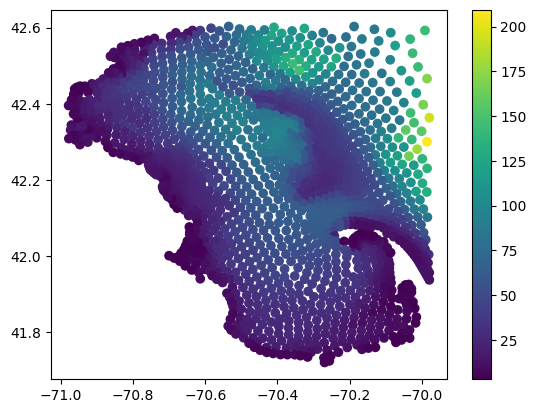

In [5]:
plt.scatter(xy[:, 0], xy[:, 1], c = h.reshape(-1))
plt.colorbar()

#### Climatology/Anomaly

In [15]:
climatology_surface, anomalies_surface = calculate_climatology(time=time, data=temp_surface[..., np.newaxis])
climatology_surface = climatology_surface.squeeze()
anomalies_surface = anomalies_surface.squeeze()

# climatology_surface_old, anomalies_surface_old = calculate_climatology_old(time=time, data=temp_surface[..., np.newaxis])
# climatology_surface_old = climatology_surface_old.squeeze()
# anomalies_surface_old = anomalies_surface_old.squeeze()

#### Calculate q, phi

In [16]:
climatology_3d, anomalies_3d = calculate_climatology(time=time, data=T)

In [7]:
from typing import Tuple, Optional
def svd_decompose(
    data: np.ndarray, n_modes: int, check: bool = False, align: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[np.ndarray]]:
    """
    Decompose data (nx, nt, nz) into:
    spatial modes phi: (nx, nz, n_modes)
    time coefficients q: (nx, nt, n_modes)

    Returns phi, q, mu, and the reconstructed projection of the data
    """
    mu = np.mean(data, axis=-1)[..., np.newaxis]  # (nx, nt, 1)

    Z = data - mu  # (nx, nt, nz)
    Z = Z.transpose((0, 2, 1))  # (nx, nz, nt)

    U, _, _ = np.linalg.svd(Z, full_matrices=False)

    phi = U[..., :n_modes]  # (nx, nz, n_modes)
    del U

    q = np.einsum("ijk,ikl->ijl", phi.transpose(0, 2, 1), Z)  # (nx, n_modes, nt)

    q = q.transpose((0, 2, 1))  # (nx, nt, n_modes)

    if align:
        flip_mask = phi[:, 0, 1] > 0
        phi[flip_mask, :, 1] *= -1
        q[flip_mask, :, 1] *= -1
    

    if check:
        proj = reconstruct_T(phi, q, mu)
        # proj = np.einsum("ijk,ikl->ijl", phi, q) + mu.transpose(0, 2, 1)  # (nx, nz, nt)
        # proj = proj.transpose((0, 2, 1))  # (nx, nt, nz)
        assert np.allclose(proj, data, atol=0.01), "Reconstruction is incorrect"

        return q, phi, mu, proj
    else:
        return q, phi, mu, None


In [19]:
q_anomaly, phi_anomaly, T_bar_anomaly, _ = svd_decompose(anomalies_3d, n_modes=2, check=False, align=True)

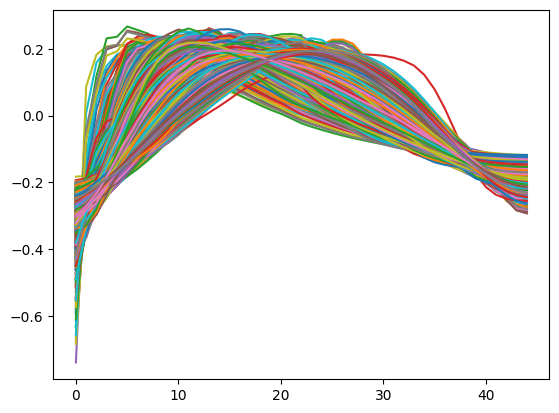

In [20]:
for row in phi_anomaly[:, :, 1]:
    plt.plot(row)

In [12]:
reconstructed_T = reconstruct_T(phi_anomaly, q_anomaly, T_bar_anomaly)

In [57]:
T_bar_anomaly.shape

(1768, 3287, 1)

In [9]:
q_anomaly.shape
q_c = T_bar_anomaly[phi_anomaly[:, 0, 1] > 0]
nq_c = T_bar_anomaly[phi_anomaly[:, 0, 1] < 0]

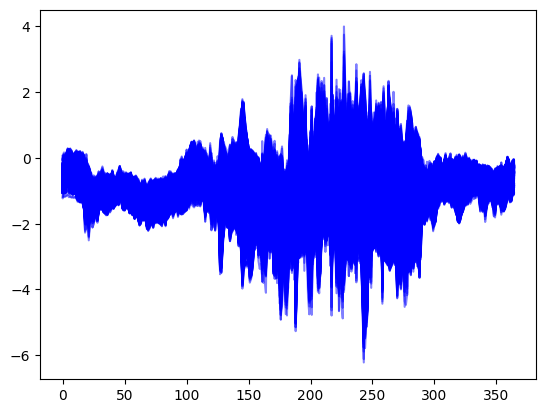

In [10]:
for row in nq_c:
    plt.plot(row[:365, 0], alpha=0.5, color='blue')

for row in q_c:
    plt.plot(row[:365, 0], alpha=0.5, color='red')

In [ ]:
phi_anomaly[:, 0, 1] > 0

In [42]:
np.save("phi_nb.npy", phi_anomaly)

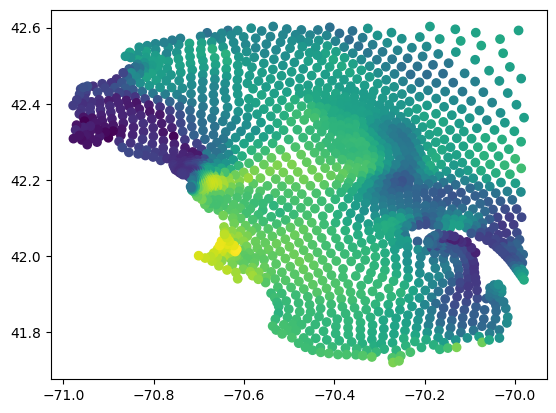

In [62]:
plt.scatter(xy[:, 0], xy[:, 1], c = anomalies_3d[:, 0, 0])

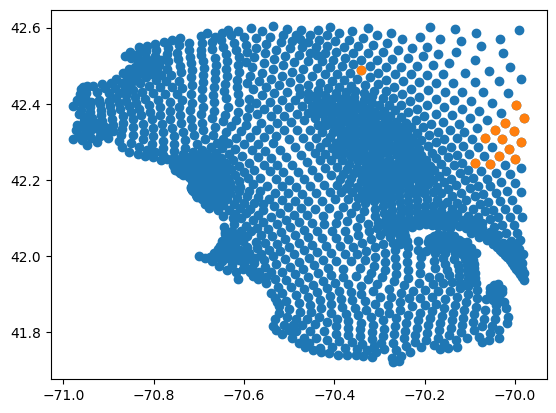

In [49]:
xy_c = xy[phi_anomaly[:, 0, 1] > 0]
# for row in phi_anomaly[:, :, 1]:
#     plt.plot(row)

plt.scatter(xy[:, 0], xy[:, 1])
plt.scatter(xy_c[:, 0], xy_c[:, 1])

#### Neighbor grouping

In [11]:
anomalies_grouped = group(data=anomalies_surface, neighbor_inds=neighbors)
climatology_grouped = group(data=climatology_surface, neighbor_inds=neighbors)

#### Build Inputs

Each timestep:
- Mean Anomaly of neighborhood
- Neighborhood anomaly STD
- Lat
- Long
- Depth

Window size: 20

In [8]:
# anomalies_mean = np.mean(anomalies_grouped, axis=-1)
# anomalies_std = np.std(anomalies_grouped, axis=-1)

# climatology_mean = np.mean(climatology_grouped, axis=-1)
# climatology_std = np.std(climatology_grouped, axis=-1)

In [13]:
anomalies_grouped[..., 0].shape

(1768, 3287)

In [15]:
np.repeat(lon, nt, axis=1).shape

(1768, 3287)

In [12]:
X = np.stack((
        anomalies_grouped[..., 0],
        anomalies_grouped[..., 1],
        anomalies_grouped[..., 2],
        anomalies_grouped[..., 3],
        anomalies_grouped[..., 4],
        climatology_surface,
        np.repeat(lon, nt, axis=1),
        np.repeat(lat, nt, axis=1),
        np.repeat(h, nt, axis=1),
), axis=2)

# X = np.stack((anomalies_mean,
#           anomalies_std, 
#           climatology_mean,
#           np.repeat(lon, nt, axis=1),
#           np.repeat(lat, nt, axis=1),
#           np.repeat(h, nt, axis=1),
# ), axis=2)

In [32]:
window_size = 20
stride = 1
sampling_rate = 1

In [33]:
X_windowed = create_windows(X, window_size=window_size, sampling_rate=sampling_rate, stride=stride)
X_windowed.shape

(1768, 3268, 20, 9)

#### Build Outputs
(T, q1, q2)

In [34]:
y = np.dstack((T_bar_anomaly, q_anomaly))
y = y[:, window_size::stride, :]

#### Build 4D Temp Field

In [15]:
T = reconstruct_T(phi, q, T_bar)

#### Save data

In [16]:
np.save(data_dir + 'preprocessed/temperature/X.npy', X_windowed)
np.save(data_dir + 'preprocessed/temperature/y.npy', y)
np.save(data_dir + 'preprocessed/temperature/T.npy', T)

#### Construct lite dataset

In [ ]:
# What we want:
# Mask that says what points have neighbors
# Mask that says what points are used in the subsample

In [36]:
from oa.preprocessing.sampling import uniform_sampling
from sklearn.cluster import KMeans

In [12]:
lon = load_mat(data_dir + 'x.mat')
lat = load_mat(data_dir + 'y.mat')
xy = np.column_stack((lon, lat))

In [37]:
has_neighbors_mask = neighbors[:, 0] != -1
has_neighbor_inds = np.where(has_neighbors_mask)[0]

In [38]:
n_samples = 1200
samples, sample_inds = uniform_sampling(xy[has_neighbors_mask], n_samples=n_samples, random_state=42)
sample_mask = np.zeros(nx, dtype=bool)
sample_mask[has_neighbor_inds[sample_inds]] = True

#### Save Uniform-sampled dataset

In [39]:
nt - 365 * 3

2192

In [40]:
n_days = nt - 365 * 3 # Exclude first 3 years
# n_days = nt

X_sample = X[sample_mask, -n_days:]
X_windowed_sample = create_windows(X_sample, window_size=window_size, sampling_rate=sampling_rate, stride=stride)

y_sample = np.dstack((T_bar_anomaly[sample_mask, -n_days:], q_anomaly[sample_mask, -n_days:]))
y_sample = create_windows(y_sample, window_size=window_size, sampling_rate=sampling_rate, stride=stride, last_only=True)

T_sample = reconstruct_T(phi_anomaly[sample_mask], q_anomaly[sample_mask, -n_days:], T_bar_anomaly[sample_mask, -n_days:])
T_sample = create_windows(T_sample, window_size=window_size, sampling_rate=sampling_rate, stride=stride, last_only=True)    

phi_sample = phi_anomaly[sample_mask]

xy_sample = xy[sample_mask]

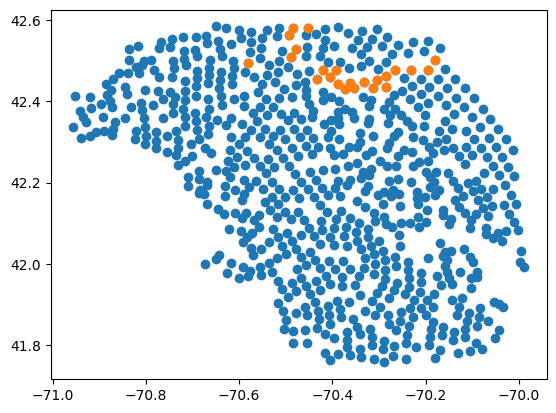

In [41]:
xy_c2 = xy_sample[phi_sample[:, 0, 1] > 0]

plt.scatter(xy_sample[:, 0], xy_sample[:, 1])
plt.scatter(xy_c2[:, 0], xy_c2[:, 1])

In [18]:
X_windowed_sample.shape

(740, 2173, 20, 9)

In [17]:
y_sample.shape

(740, 2173, 3)

In [23]:
X_windowed_sample.shape


(740, 2172, 20, 9)

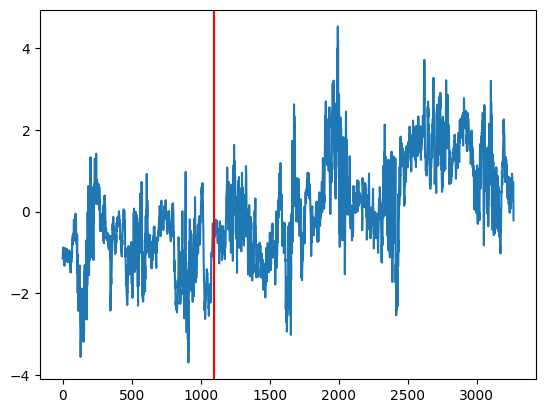

In [60]:
plt.plot(T_sample[0, :, 0])
# Vertical line at the end of the third year
plt.axvline(365 * 3, color='red')

In [71]:
np.save(data_dir + 'preprocessed/salinity/sample/X.npy', X_windowed_sample)
np.save(data_dir + 'preprocessed/salinity/sample/y.npy', y_sample)
np.save(data_dir + 'preprocessed/salinity/sample/T.npy', T_sample)
np.save(data_dir + 'preprocessed/salinity/sample/phi.npy', phi_sample)
np.save(data_dir + 'preprocessed/salinity/sample/xy.npy', xy_sample)

: 

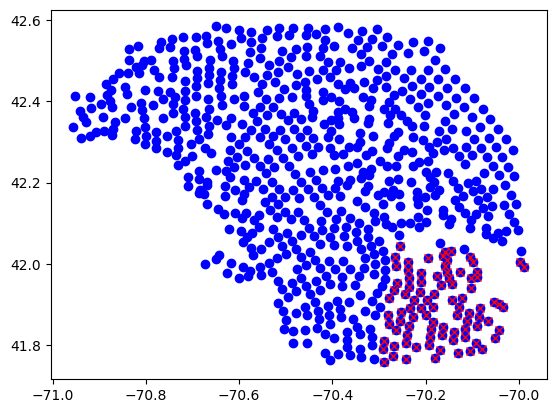

In [39]:
cluster_size = 100
num_clusters = int(len(samples) / cluster_size)  # Adjust this number based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(samples)
selected_cluster = np.where(clusters == 1)[0]

cluster_mask = np.zeros(nx, dtype=bool)
cluster_mask[has_neighbor_inds[sample_inds[selected_cluster]]] = True

plt.plot(xy[sample_mask][:, 0], xy[sample_mask][:, 1], 'bo')
plt.plot(xy[cluster_mask][:, 0], xy[cluster_mask][:, 1], 'rx')
# plt.plot(samples[selected_cluster, 0], samples[selected_cluster, 1], 'rx')
# Plot the 40th point in the cluster in yellow
# plt.plot(samples[selected_cluster, 0][110], samples[selected_cluster, 1][110], 'yo')

In [66]:
# Build the lite dataset from the selected spatial cluster and the last year of data
# n_days = 365 * 2
n_days = nt - 365 * 3 # Exclude first 3 years

X_lite = X[cluster_mask, -n_days:]
X_windowed_lite = create_windows(X_lite, window_size=window_size, sampling_rate=sampling_rate, stride=stride)

y_lite = np.dstack((T_bar_anomaly[cluster_mask, -n_days:], q_anomaly[cluster_mask, -n_days:]))
y_lite = y_lite[:, window_size::stride, :]

T_lite = reconstruct_T(phi_anomaly[cluster_mask], q_anomaly[cluster_mask, -n_days:], T_bar_anomaly[cluster_mask, -n_days:])[:, window_size::stride, :]

In [67]:
X_windowed_lite.shape, y_lite.shape, T_lite.shape

((88, 2172, 20, 9), (88, 2172, 3), (88, 2172, 45))

In [69]:
np.save(data_dir + 'preprocessed/temperature/lite_sample_2/X.npy', X_windowed_lite)
np.save(data_dir + 'preprocessed/temperature/lite_sample_2/y.npy', y_lite)
np.save(data_dir + 'preprocessed/temperature/lite_sample_2/T.npy', T_lite)

In [44]:
np.save(data_dir + 'preprocessed/temperature/phi_lite.npy', phi_anomaly[cluster_mask])